# GPVAE model
The main difference to traditional VAE model (Kigma et al., 2014) is that instead of using standard gaussian distibutions on the latent vector $\mathbf{Z} = [\mathbf{z}_1, \ldots, \mathbf{z}_L],$ where $\mathbf{z}_l \sim \mathcal{N}(0, \sigma^2I),$ we use GPs that account for the depedency that we have in time. Therefore we have that $\mathbf{z}_l \sim \mathcal{N}(0, K(t,t'\mid \theta_l)),$ where $K$ is a function that models the correlation that we have in time. 

This is in principle a conditional (in time) generator. Another advantage of using GPs for the latent variables, is that we do not need the data to be equally spaced in time. It is also possible to condition on other features. For example, the outer temperature, solar irradiance, wind, ...

The main drawback with GPs is the cubic in data $\mathcal{O}(N^3)$ cost and the vanilla GP model can not be trained in mini-batches.
To overcome the cost we can use reliable approximations (e.g. Titsias 2009) that reduce the cost to $\mathcal{O}(Nm^2),$ where $m$ is a user the number of so called inducing points (user choice, usually 20-30 is fine). At the same time there are two recent papers that make GPs ammenable to mini-batching (add refs).

In [32]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
from torch.utils.data import Dataset, DataLoader,random_split, Subset
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from GP import *
from Models.GPVAE import GPVAE

import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file
warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)

In [2]:
# Import RICO data 
file_path = '../Data/RICO4_Dataset_processed.hdf'
df = pd.read_hdf(file_path)

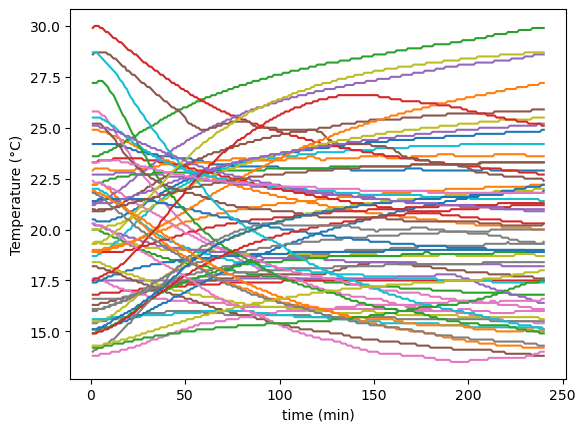

In [3]:
for i in df['interval'].unique():
    id = df['interval'] == i
    plt.plot(df[id]['time_within_interval'].to_numpy(), df[id]['B.RTD1'].to_numpy())
plt.xlabel('time (min)')
plt.ylabel('Temperature (°C)')
plt.show()

In [4]:
df_h = df[df['temp_change_class'] == 'h']

In [5]:
def select_points(group):
    return group.iloc[::10]  # Select every 10th row
df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)

/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_92671/1449435483.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)


In [6]:
class RICO4Dataset(Dataset):
    def __init__(self, df_h):
        self.df_h = df_h
        self.unique_intervals = df_h['interval'].unique()

    def __len__(self):
        return len(self.unique_intervals)

    def __getitem__(self, idx):
        batch = self.unique_intervals[idx]
        id = self.df_h['interval'] == batch
        temp = torch.tensor(self.df_h[id]['B.RTD1'].to_numpy(), dtype=torch.float32)
        ti = torch.tensor(self.df_h[id]['time_within_interval'].to_numpy()/240, dtype=torch.float32)
        x_batch = torch.cat((temp.unsqueeze(1), ti.unsqueeze(1)), axis=1)
        return x_batch


In [7]:
dataset = RICO4Dataset(df_h)
# Define split ratios
train_ratio = 0.7
test_ratio = 1-train_ratio

# Calculate split sizes
total_size = len(dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

seed = 0
generator = torch.Generator().manual_seed(seed)

# Split the dataset
train_subset, test_subset = random_split(
    dataset,
    [train_size, test_size],
    generator=generator
)

In [8]:
train_loader = DataLoader(train_subset, batch_size=1, shuffle=False)
val_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

In [9]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))

# Initialize the VAE
torch.manual_seed(1)
model = GPVAE(GP_inf = GP_inference(kernel),# GP_inference(kernel,mean_GP), 
              activation_decoder=nn.ReLU(),
              hidden_layers_encoder=[10])

In [10]:
gp_params = []
base_params = []

for name, param in model.named_parameters():
    if 'GP' in name:
        gp_params.append(param)  # Gaussian Process parameters
    else:
        base_params.append(param)  # Other parameters

base_lr = 0.001  # Learning rate for base parameters
gp_lr = 0.0001  # Learning rate for GP parameters
# Create separate parameter groups in the optimizer
opt = torch.optim.Adam([
    {'params': base_params, 'lr': base_lr},
    {'params': gp_params, 'lr': gp_lr}
])
opt.zero_grad()


In [11]:
t_uni=torch.tensor(
    [  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.]
)
t_uni

tensor([  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.])

Training Progress:   5%|▍         | 16/350 [00:01<00:31, 10.52it/s]

Epoch 17:
  Training - Loss = 114.9605, KL = 0.4829, MSE = 115.4434, CE = 3.1356
  Validation - Loss = 112.4919, KL = 0.4813, MSE = 112.9732, CE = 3.0935
  Mean q_mu = 2.0127, Mean q_var = 28.3927


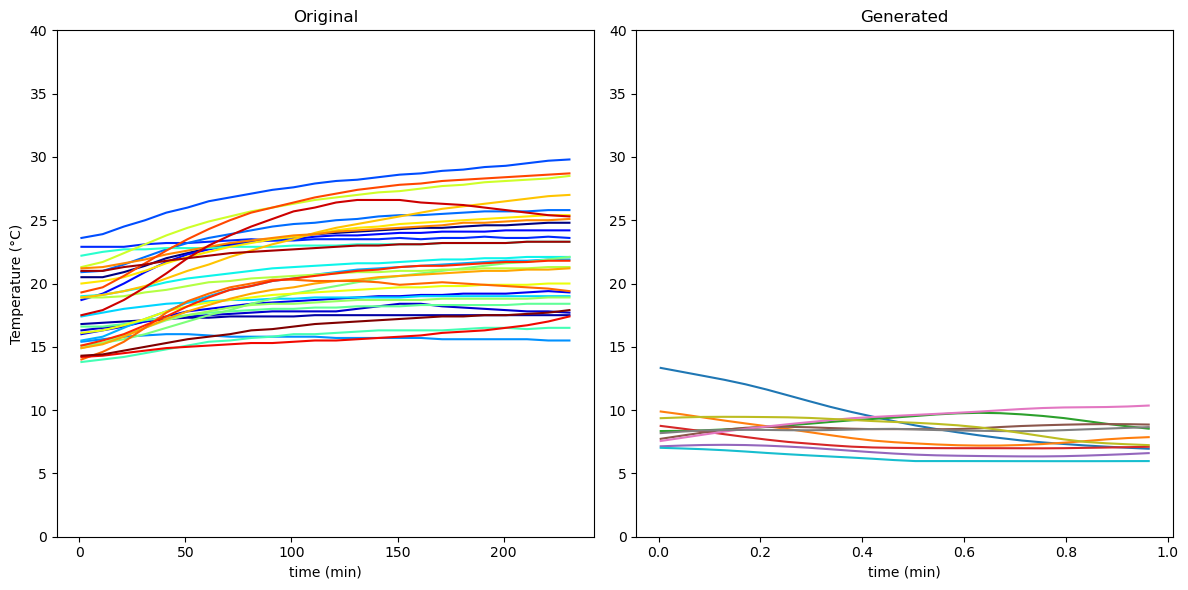

Training Progress:   9%|▉         | 32/350 [00:03<00:29, 10.65it/s]

Epoch 34:
  Training - Loss = 13.3618, KL = 0.4386, MSE = 13.8004, CE = 1.5822
  Validation - Loss = 13.6499, KL = 0.4383, MSE = 14.0881, CE = 1.5999
  Mean q_mu = 0.7748, Mean q_var = 1.2941


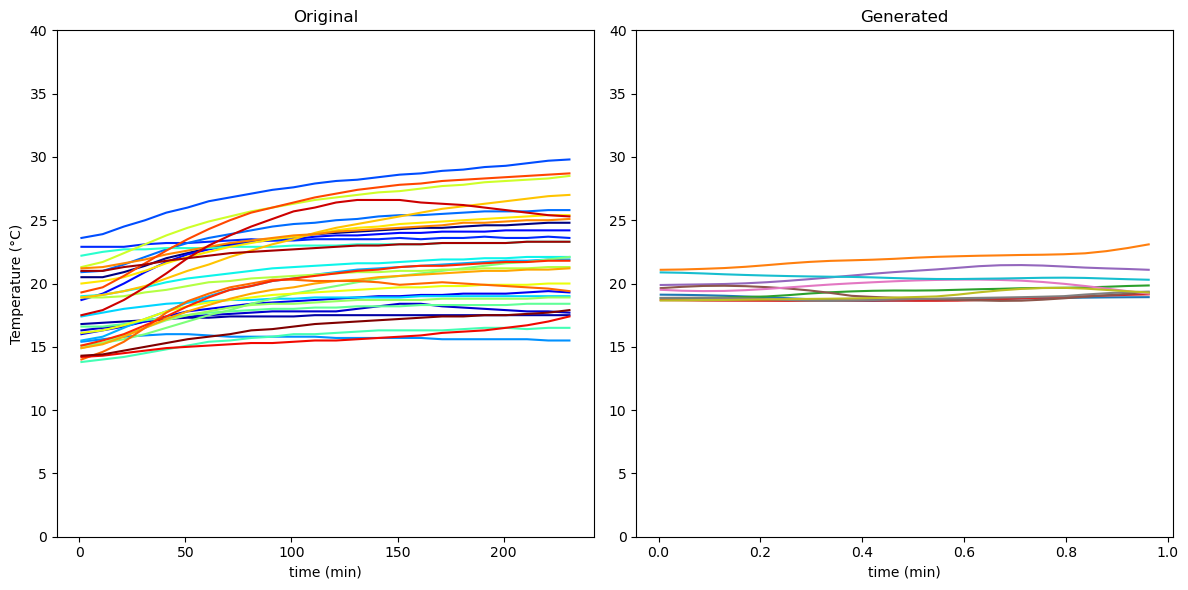

Training Progress:  14%|█▍        | 50/350 [00:05<00:27, 11.07it/s]

Epoch 51:
  Training - Loss = 12.1631, KL = 0.4093, MSE = 12.5724, CE = 1.2689
  Validation - Loss = 11.7560, KL = 0.4055, MSE = 12.1615, CE = 1.2782
  Mean q_mu = 0.8939, Mean q_var = 0.6767


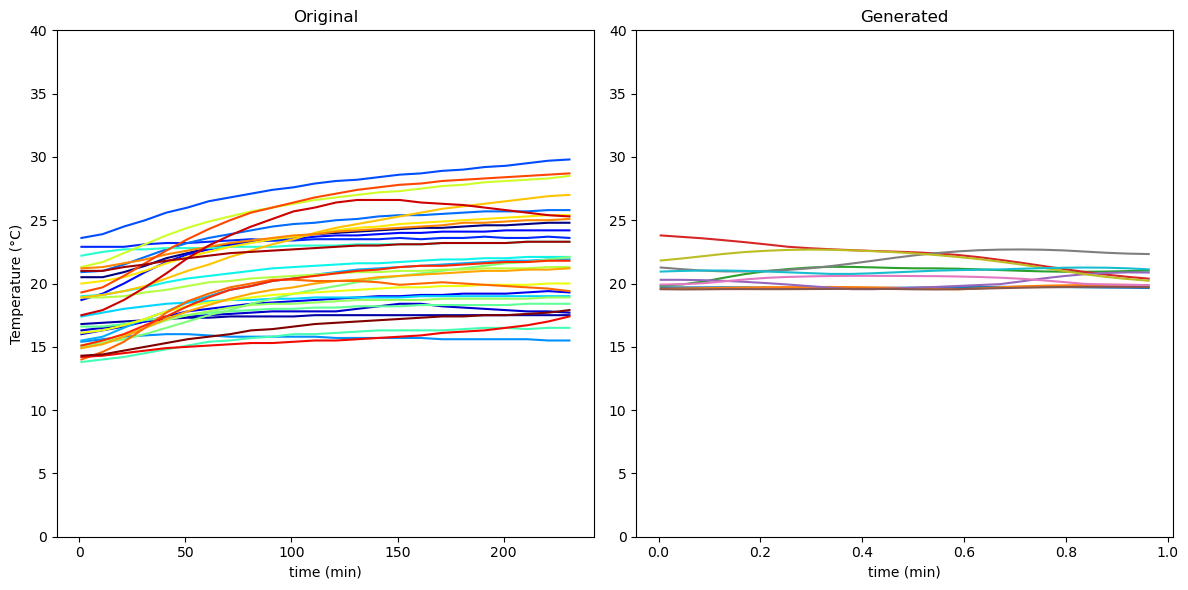

Training Progress:  19%|█▉        | 66/350 [00:06<00:26, 10.65it/s]

Epoch 68:
  Training - Loss = 10.5373, KL = 0.3815, MSE = 10.9188, CE = 1.1070
  Validation - Loss = 11.1438, KL = 0.3743, MSE = 11.5181, CE = 1.1133
  Mean q_mu = 1.0723, Mean q_var = 0.4845


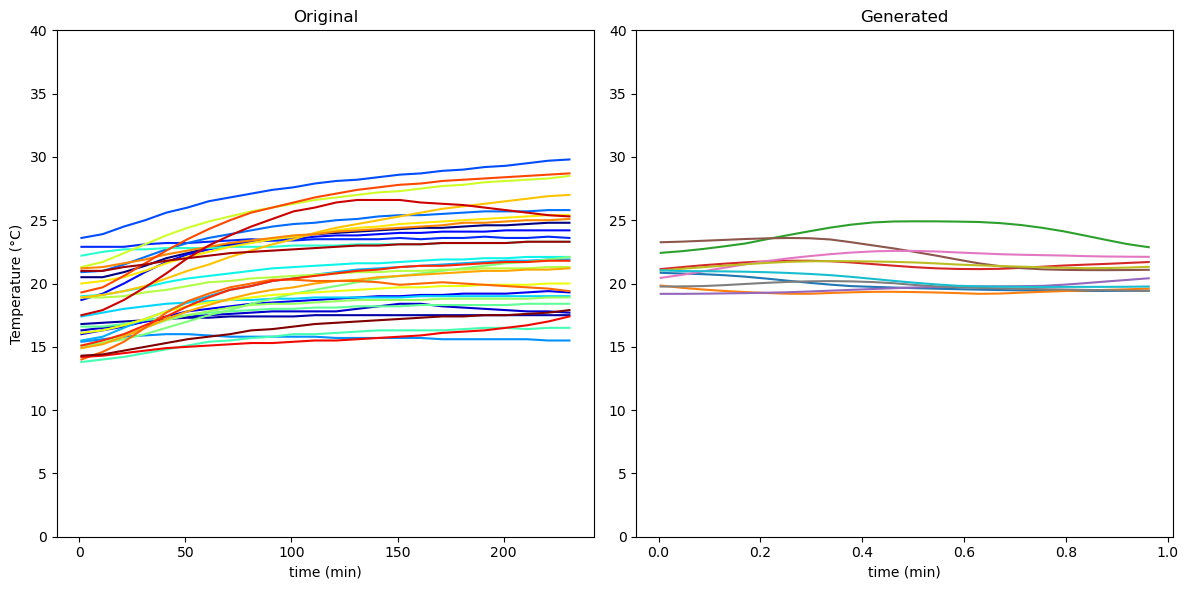

Training Progress:  24%|██▍       | 84/350 [00:08<00:24, 10.94it/s]

Epoch 85:
  Training - Loss = 8.3402, KL = 0.3387, MSE = 8.6789, CE = 0.8495
  Validation - Loss = 7.8493, KL = 0.3265, MSE = 8.1758, CE = 0.8579
  Mean q_mu = 1.2322, Mean q_var = 0.2848


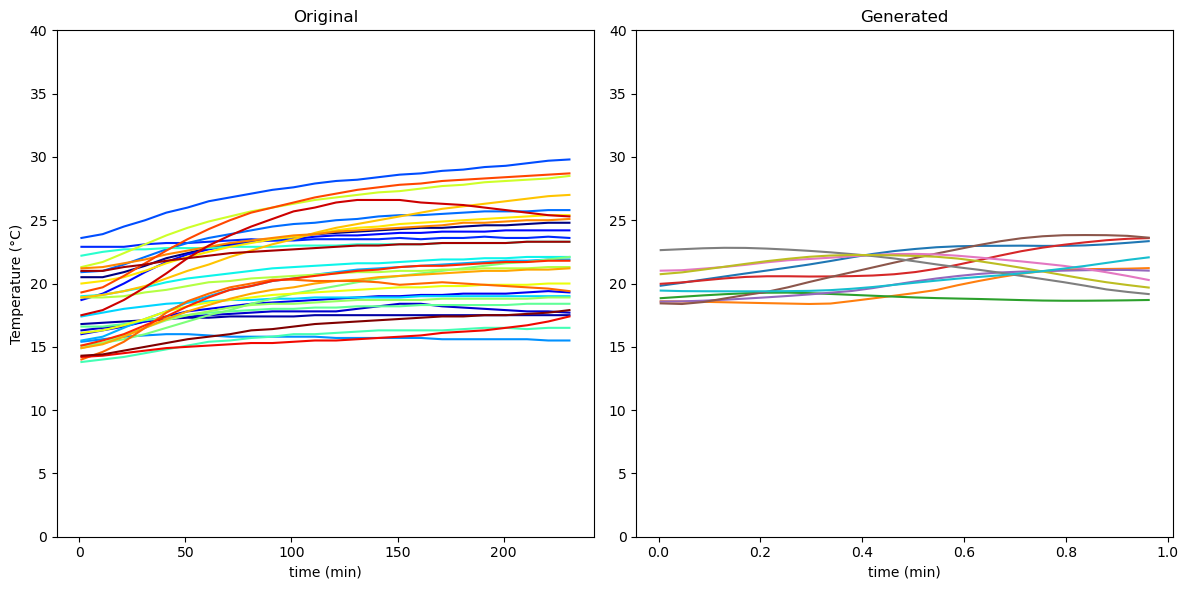

Training Progress:  29%|██▉       | 101/350 [00:10<00:23, 10.71it/s]

Epoch 102:
  Training - Loss = 4.1035, KL = 0.3000, MSE = 4.4034, CE = 0.5954
  Validation - Loss = 3.8607, KL = 0.2798, MSE = 4.1405, CE = 0.6038
  Mean q_mu = 1.2368, Mean q_var = 0.1682


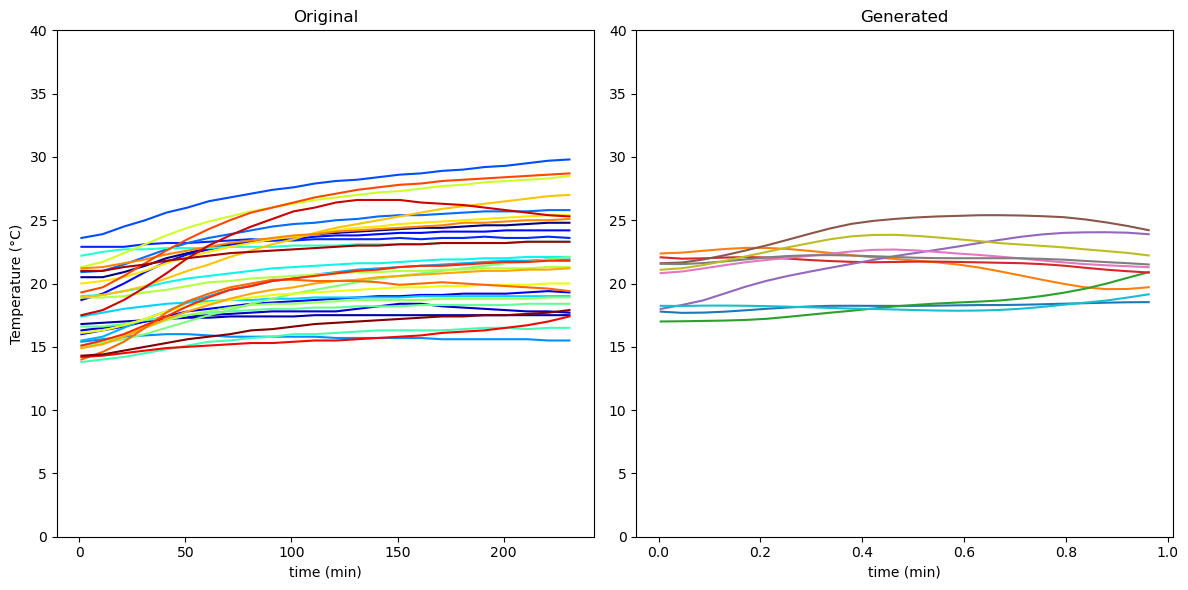

Training Progress:  34%|███▎      | 118/350 [00:11<00:21, 10.98it/s]

Epoch 119:
  Training - Loss = 2.0989, KL = 0.2619, MSE = 2.3608, CE = 0.3298
  Validation - Loss = 1.9370, KL = 0.2312, MSE = 2.1683, CE = 0.3398
  Mean q_mu = 1.1610, Mean q_var = 0.0970


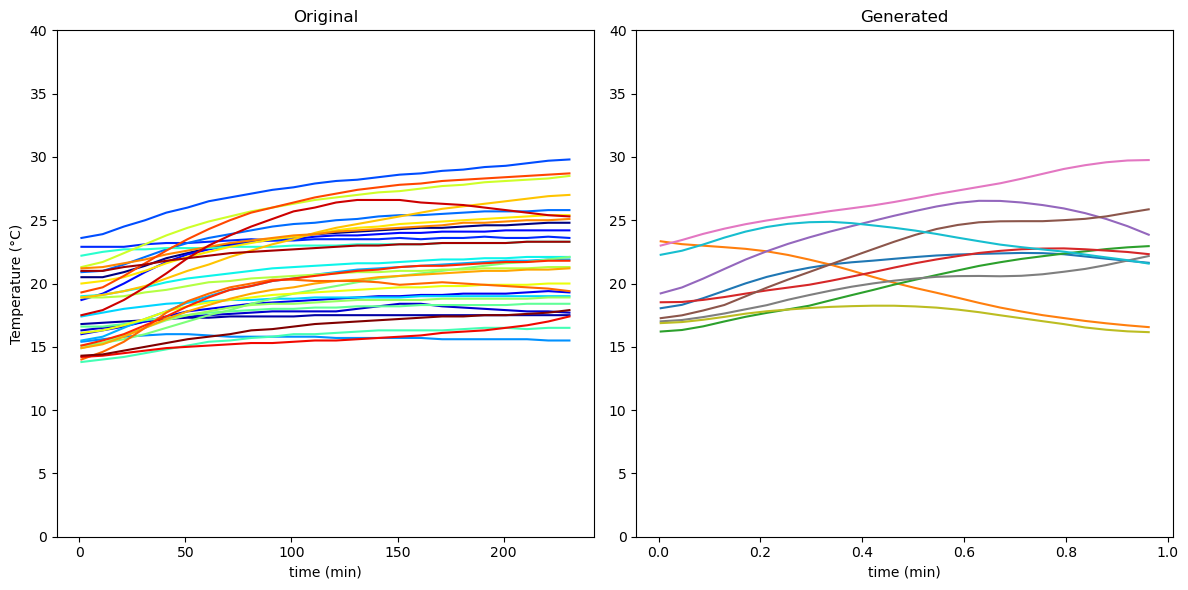

Training Progress:  39%|███▊      | 135/350 [00:13<00:19, 11.03it/s]

Epoch 136:
  Training - Loss = 1.0091, KL = 0.2279, MSE = 1.2370, CE = 0.0955
  Validation - Loss = 0.9632, KL = 0.1974, MSE = 1.1606, CE = 0.1067
  Mean q_mu = 1.1042, Mean q_var = 0.0597


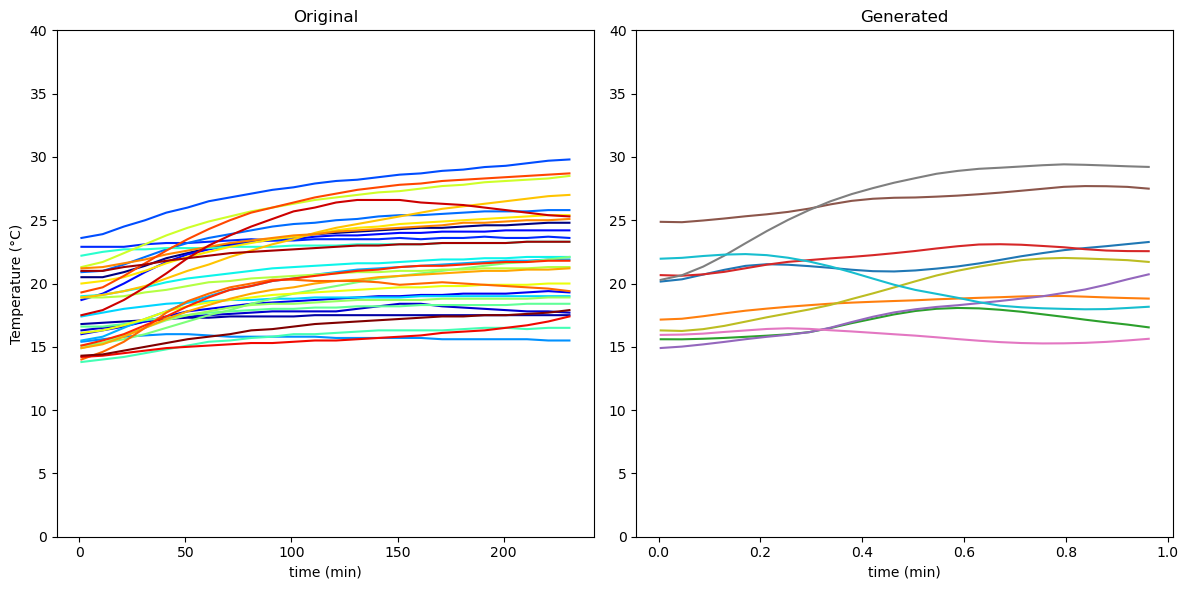

Training Progress:  43%|████▎     | 152/350 [00:15<00:19, 10.22it/s]

Epoch 153:
  Training - Loss = 0.7988, KL = 0.2128, MSE = 1.0116, CE = 0.0134
  Validation - Loss = 0.8166, KL = 0.1716, MSE = 0.9882, CE = 0.0302
  Mean q_mu = 1.0536, Mean q_var = 0.0503


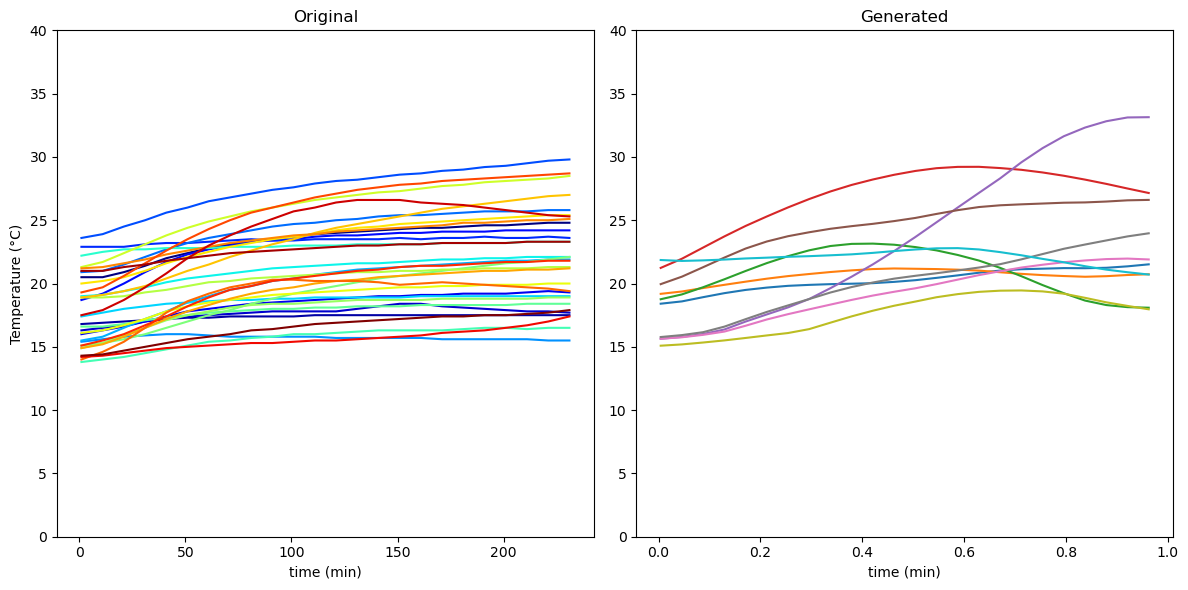

Training Progress:  48%|████▊     | 168/350 [00:17<00:17, 10.62it/s]

Epoch 170:
  Training - Loss = 0.6218, KL = 0.2062, MSE = 0.8280, CE = 0.0134
  Validation - Loss = 0.7457, KL = 0.1632, MSE = 0.9089, CE = 0.0295
  Mean q_mu = 1.0366, Mean q_var = 0.0502


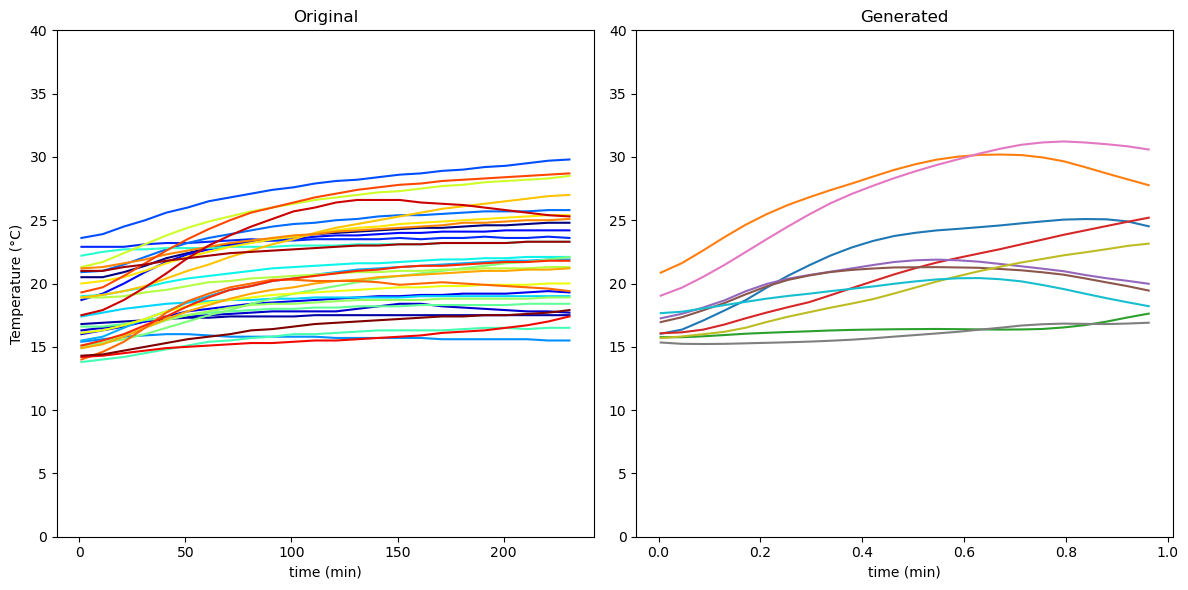

Training Progress:  53%|█████▎    | 186/350 [00:18<00:14, 11.08it/s]

Epoch 187:
  Training - Loss = 0.5285, KL = 0.1939, MSE = 0.7224, CE = 0.0134
  Validation - Loss = 0.7166, KL = 0.1516, MSE = 0.8682, CE = 0.0307
  Mean q_mu = 1.1210, Mean q_var = 0.0500


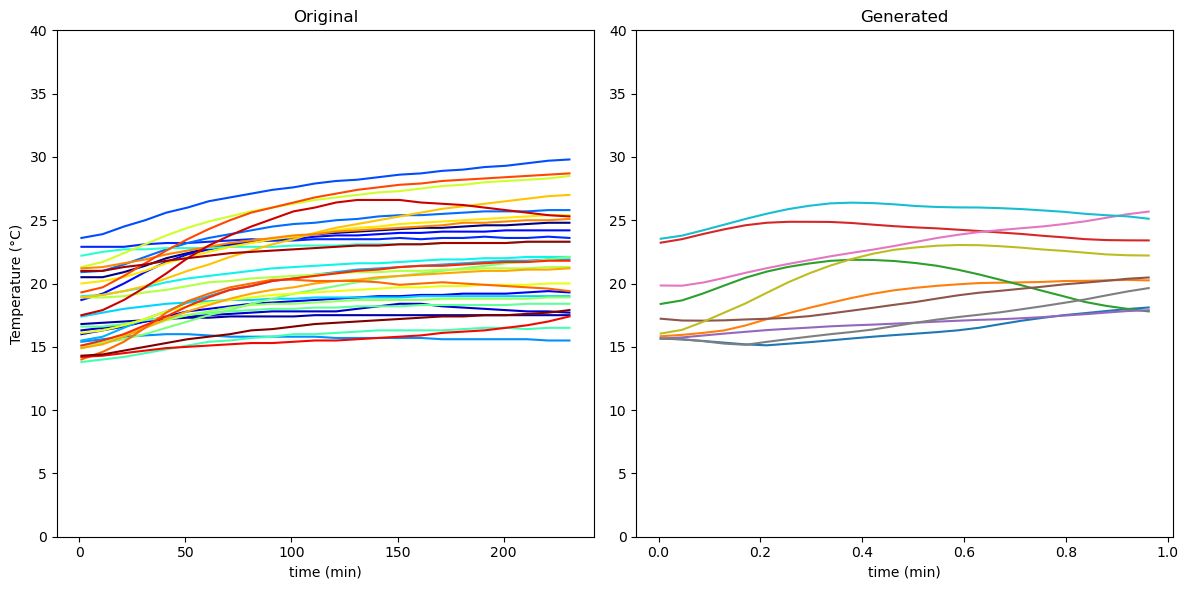

Training Progress:  58%|█████▊    | 203/350 [00:20<00:13, 10.79it/s]

Epoch 204:
  Training - Loss = 0.6285, KL = 0.1806, MSE = 0.8091, CE = 0.0153
  Validation - Loss = 0.6122, KL = 0.1281, MSE = 0.7402, CE = 0.0360
  Mean q_mu = 1.2014, Mean q_var = 0.0501


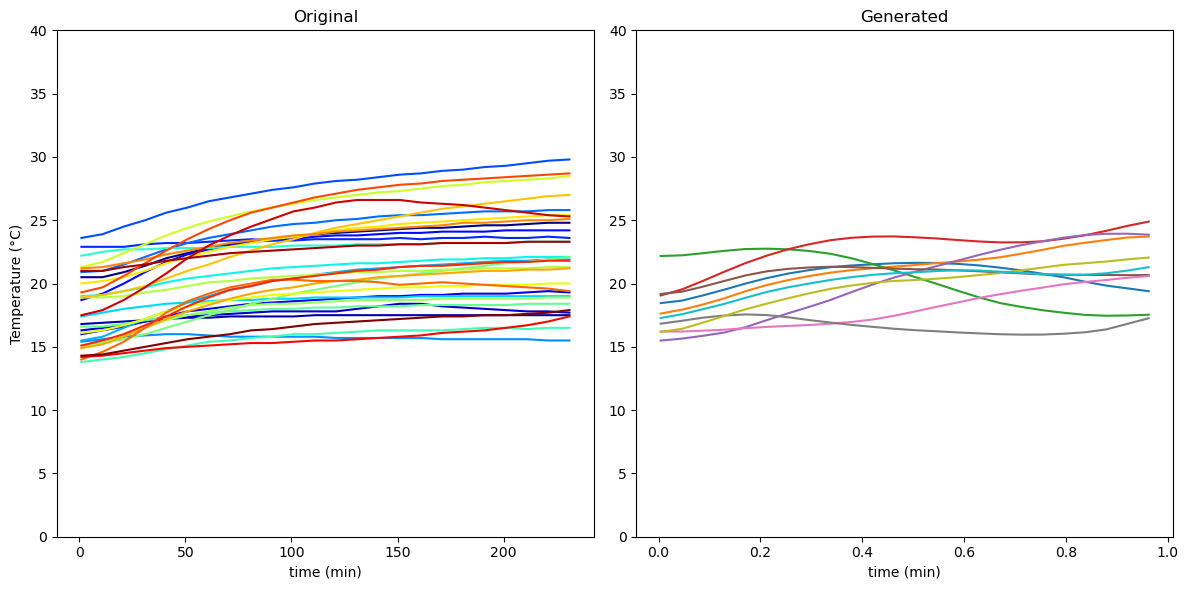

Training Progress:  63%|██████▎   | 219/350 [00:22<00:12, 10.11it/s]

Epoch 221:
  Training - Loss = 0.5670, KL = 0.1699, MSE = 0.7369, CE = 0.0170
  Validation - Loss = 0.6773, KL = 0.1105, MSE = 0.7878, CE = 0.0407
  Mean q_mu = 1.2298, Mean q_var = 0.0501


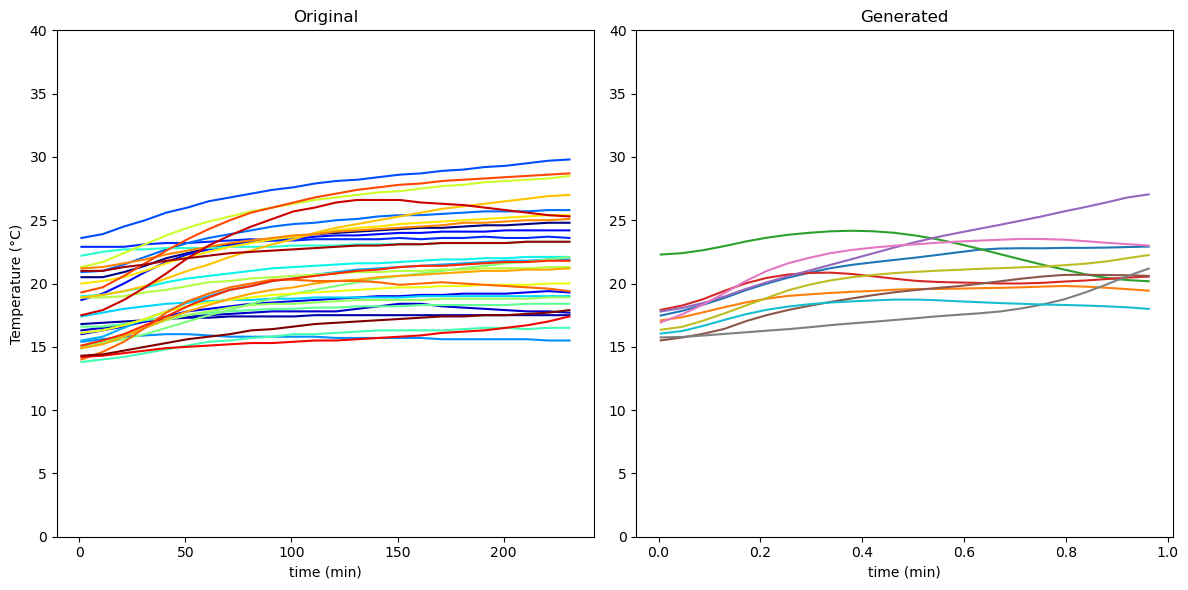

Training Progress:  68%|██████▊   | 237/350 [00:24<00:10, 10.91it/s]

Epoch 238:
  Training - Loss = 0.5054, KL = 0.1611, MSE = 0.6665, CE = 0.0186
  Validation - Loss = 0.5185, KL = 0.0998, MSE = 0.6183, CE = 0.0436
  Mean q_mu = 1.2330, Mean q_var = 0.0500


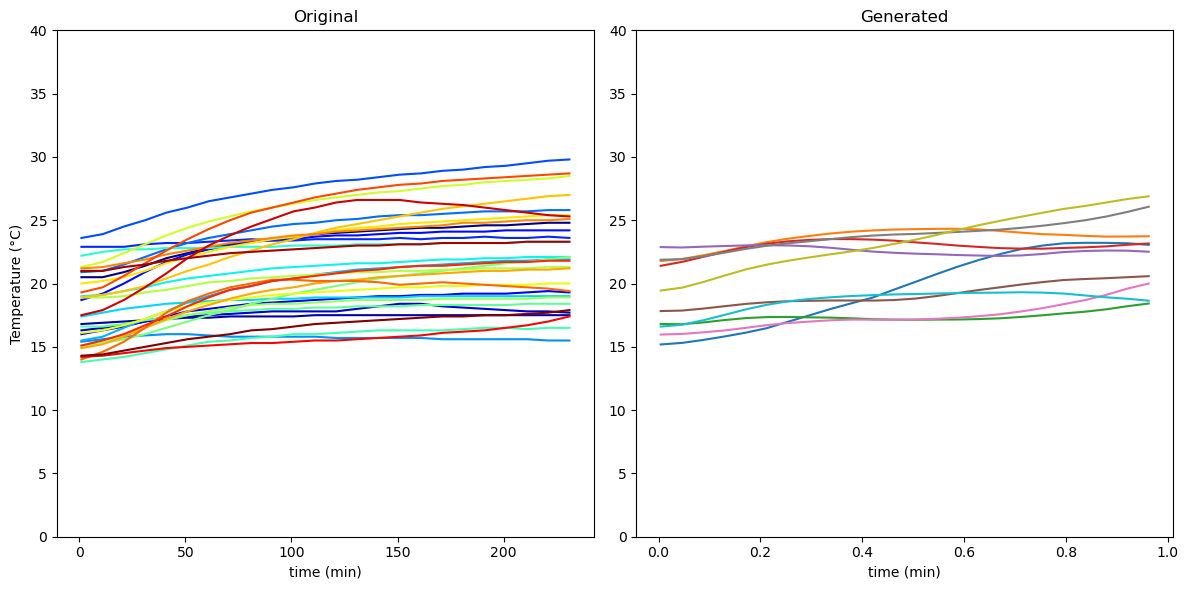

Training Progress:  73%|███████▎  | 254/350 [00:25<00:08, 10.97it/s]

Epoch 255:
  Training - Loss = 0.3825, KL = 0.1513, MSE = 0.5338, CE = 0.0194
  Validation - Loss = 0.5595, KL = 0.0851, MSE = 0.6446, CE = 0.0469
  Mean q_mu = 1.2560, Mean q_var = 0.0499


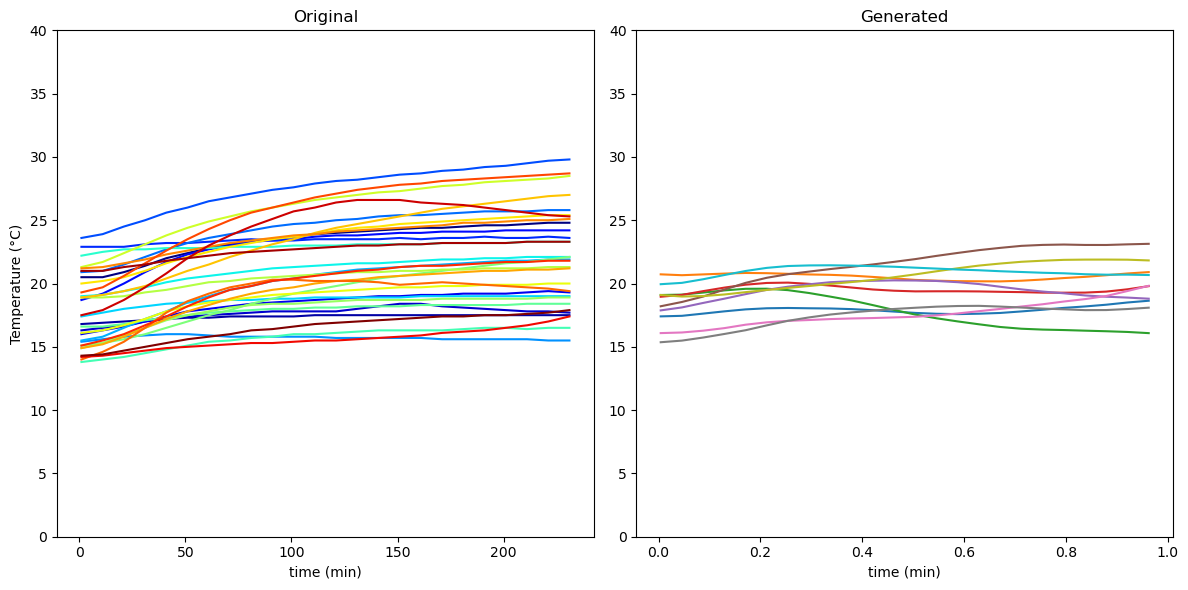

Training Progress:  77%|███████▋  | 270/350 [00:27<00:07, 10.84it/s]

Epoch 272:
  Training - Loss = 0.3940, KL = 0.1448, MSE = 0.5388, CE = 0.0205
  Validation - Loss = 0.5253, KL = 0.0715, MSE = 0.5968, CE = 0.0503
  Mean q_mu = 1.2337, Mean q_var = 0.0498


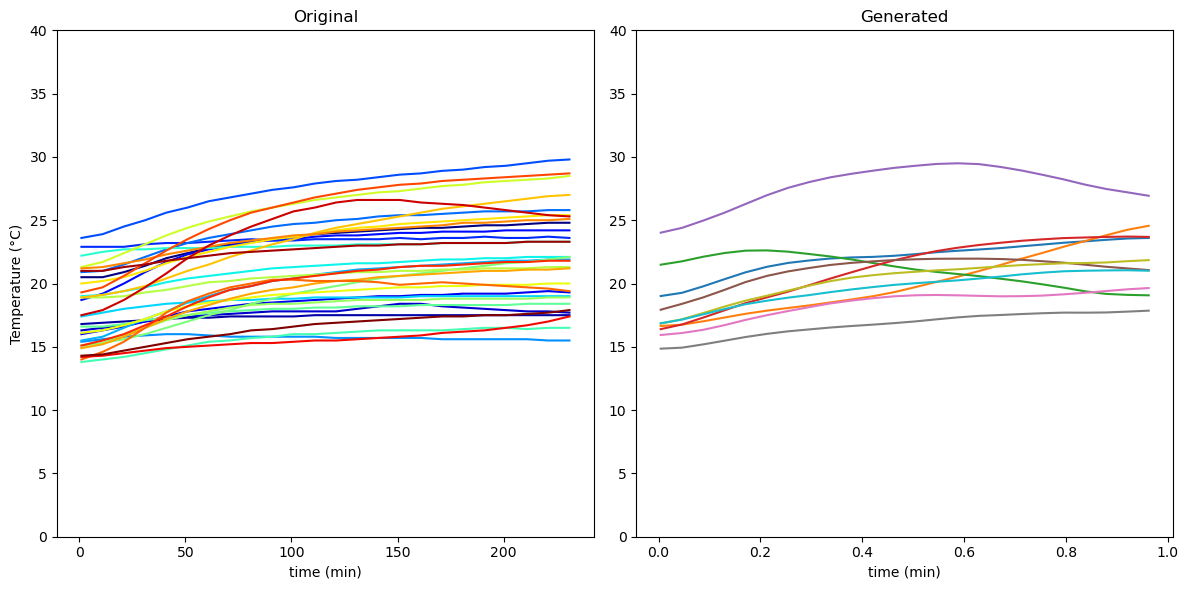

Training Progress:  82%|████████▏ | 288/350 [00:29<00:05, 10.95it/s]

Epoch 289:
  Training - Loss = 0.3910, KL = 0.1351, MSE = 0.5261, CE = 0.0221
  Validation - Loss = 0.5531, KL = 0.0661, MSE = 0.6191, CE = 0.0530
  Mean q_mu = 1.2400, Mean q_var = 0.0498


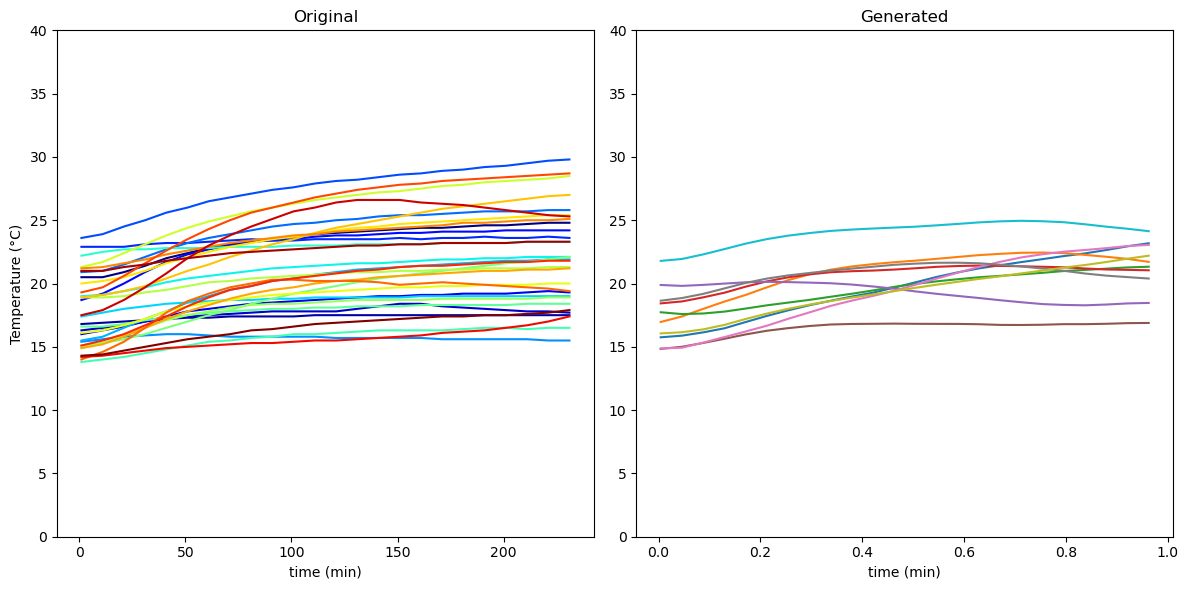

Training Progress:  87%|████████▋ | 304/350 [00:30<00:04, 10.88it/s]

Epoch 306:
  Training - Loss = 0.3386, KL = 0.1314, MSE = 0.4699, CE = 0.0238
  Validation - Loss = 0.4098, KL = 0.0622, MSE = 0.4720, CE = 0.0562
  Mean q_mu = 1.1833, Mean q_var = 0.0498


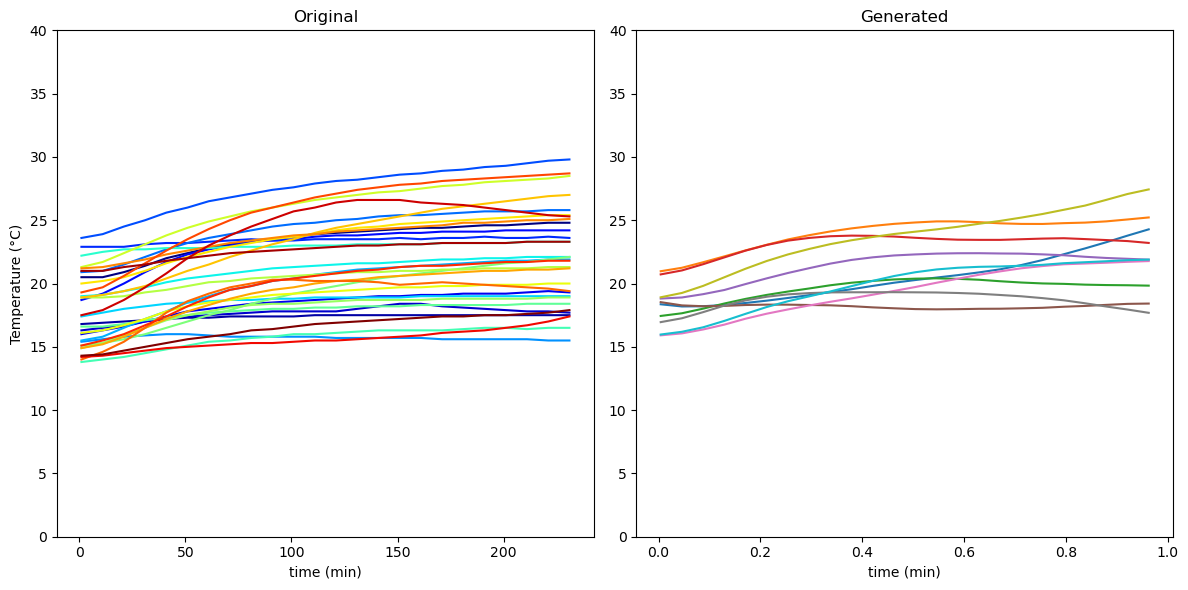

Training Progress:  92%|█████████▏| 322/350 [00:32<00:02, 10.87it/s]

Epoch 323:
  Training - Loss = 0.3017, KL = 0.1256, MSE = 0.4273, CE = 0.0251
  Validation - Loss = 0.3988, KL = 0.0390, MSE = 0.4378, CE = 0.0607
  Mean q_mu = 1.1832, Mean q_var = 0.0498


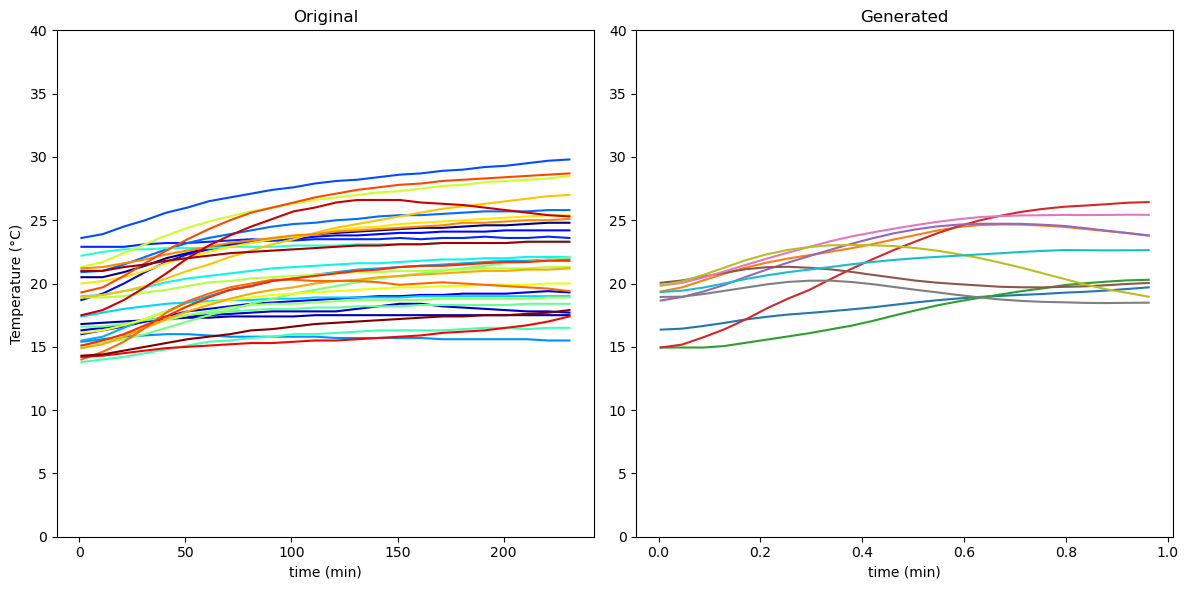

Training Progress:  97%|█████████▋| 339/350 [00:34<00:00, 11.07it/s]

Epoch 340:
  Training - Loss = 0.3395, KL = 0.1194, MSE = 0.4589, CE = 0.0269
  Validation - Loss = 0.4616, KL = 0.0377, MSE = 0.4993, CE = 0.0633
  Mean q_mu = 1.1339, Mean q_var = 0.0498


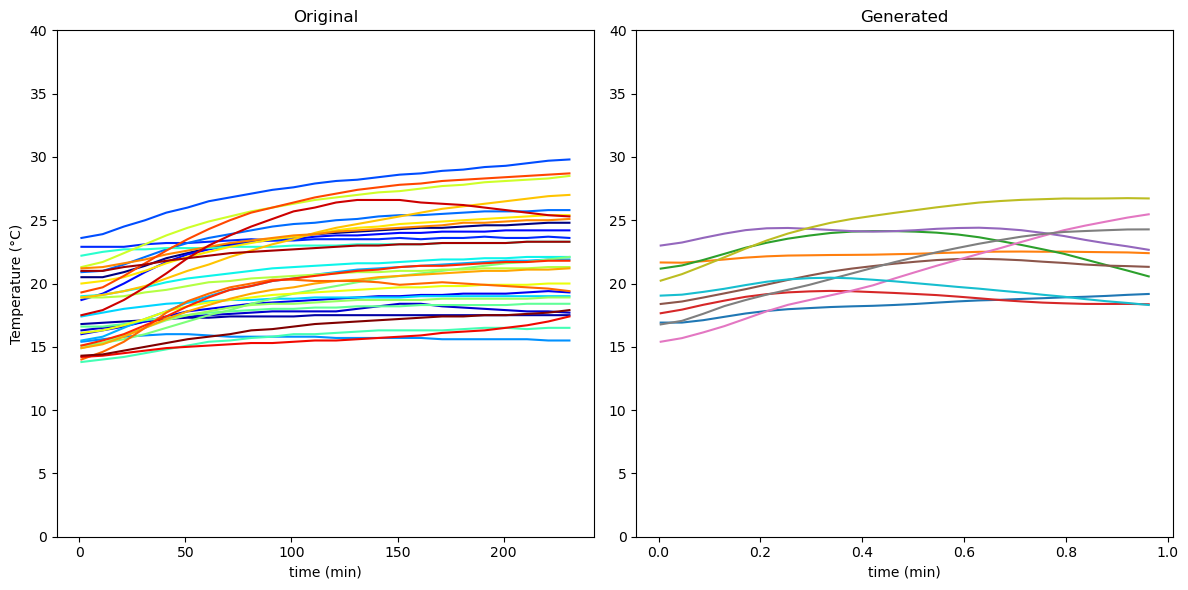

Training Progress: 100%|█████████▉| 349/350 [00:35<00:00, 10.59it/s]

Epoch 350:
  Training - Loss = 0.2919, KL = 0.1158, MSE = 0.4077, CE = 0.0278
  Validation - Loss = 0.3872, KL = 0.0403, MSE = 0.4275, CE = 0.0641
  Mean q_mu = 1.1138, Mean q_var = 0.0498


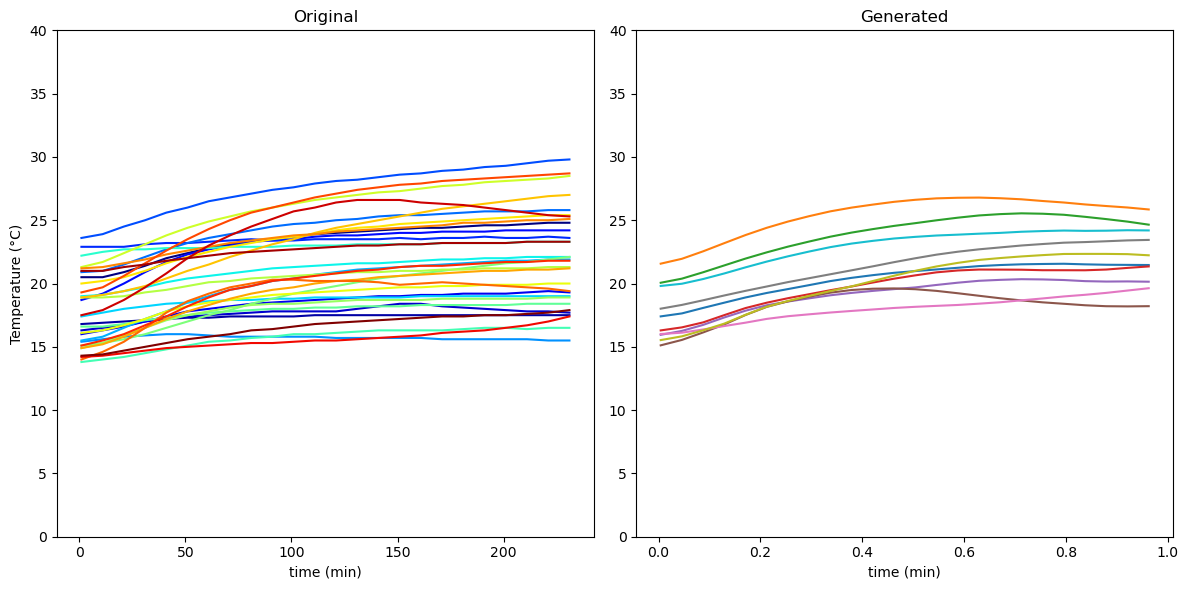

Training Progress: 100%|██████████| 350/350 [00:35<00:00,  9.90it/s]


In [12]:
# beta = 0.01
beta = 1
num_epochs = 350
torch.manual_seed(123)
metrics = model.fit(train_loader, val_loader, 
                    opt, beta, num_epochs, 
                    t_uni=t_uni/240, 
                    num_samples=10, 
                    ylim=(0,40), 
                    df=df_h, 
                    plot=True)# model.fit(train_loader, val_loader, opt, beta, num_epochs)

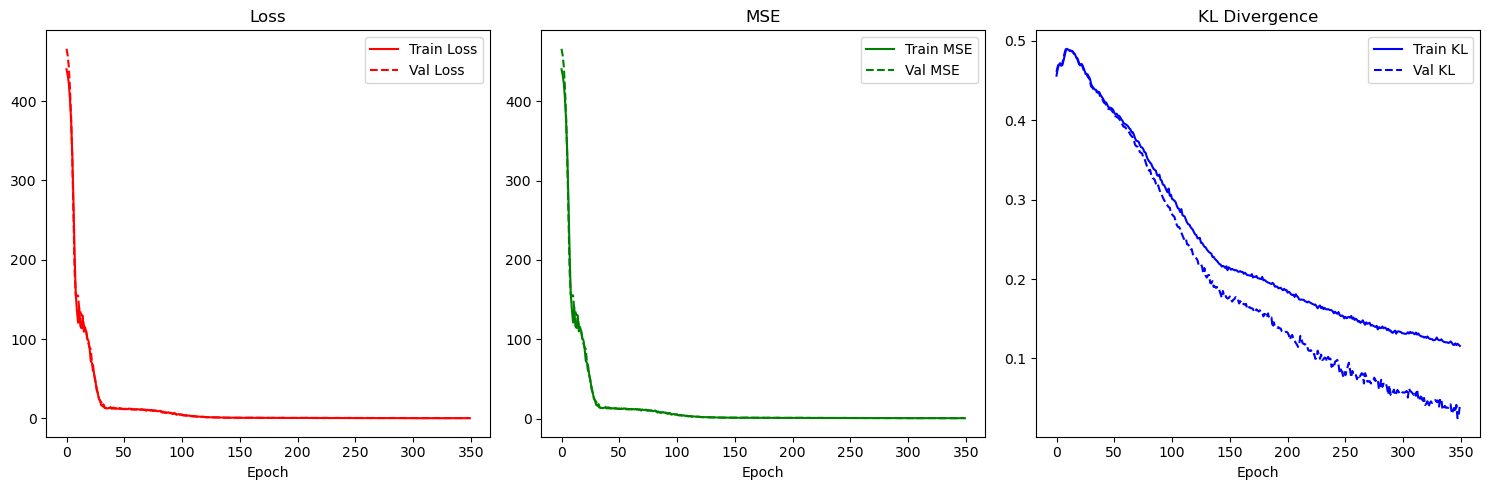

In [13]:
# Extracting training and validation metrics from the dictionary
epochs = range(num_epochs)
train_loss = metrics['train_loss']
val_loss = metrics['val_loss']
train_mse = metrics['train_mse']
val_mse = metrics['val_mse']
train_KL = metrics['train_KL']
val_KL = metrics['val_KL']

# Create subplots for Loss, MSE, and KL Divergence with both train and validation metrics
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Loss plot (train and validation)
axs[0].plot(epochs, train_loss, 'r-', label='Train Loss')
axs[0].plot(epochs, val_loss, 'r--', label='Val Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# MSE plot (train and validation)
axs[1].plot(epochs, train_mse, 'g-', label='Train MSE')
axs[1].plot(epochs, val_mse, 'g--', label='Val MSE')
axs[1].set_title('MSE')
axs[1].set_xlabel('Epoch')
axs[1].legend()

# KL Divergence plot (train and validation)
axs[2].plot(epochs, train_KL, 'b-', label='Train KL')
axs[2].plot(epochs, val_KL, 'b--', label='Val KL')
axs[2].set_title('KL Divergence')
axs[2].set_xlabel('Epoch')
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [14]:
# Initialize lists to collect only the required results
x_hat_l, q_mu_l, q_var_l = [], [], []

for x_batch in dataset:
    with torch.no_grad():
        x_hat_i, _, _, _, q_mu_i, q_var_i = model(x_batch.squeeze())  # Only retrieve required outputs
        
        # Append results to respective lists
        x_hat_l.append(x_hat_i)
        q_mu_l.append(q_mu_i)
        q_var_l.append(q_var_i)
        
mean_q_mu = sum(q_mu_l) / len(q_mu_l)
mean_q_var = sum(q_var_l) / len(q_var_l)

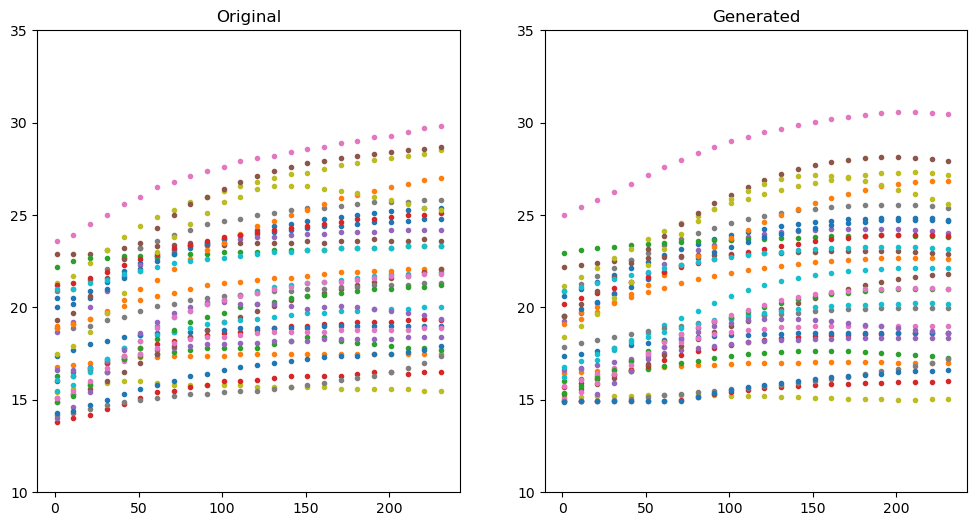

In [15]:
ns = 1
latent_dim=1
colors = plt.cm.jet(np.linspace(0, 10, ns))  # Using the 'jet' colormap; you can choose another
np.random.shuffle(colors)

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns, optional figure size
axs[0].set_ylim(10, 35)
axs[1].set_ylim(10, 35)


for l in range(len(q_mu_l)):
    mu, var = [], []
    for i in range(latent_dim):
        with torch.no_grad():
            mu, var, _ = model.GP(X=t_uni/240, y=q_mu_l[l], q_var=q_var_l[l].squeeze())

    for i in range(ns):
        with torch.no_grad():
            z = model.reparameterization(mu, var.diag())
            dec = model.decode(z)
        axs[1].plot(t_uni, dec.numpy(), 'o', markersize=3)    

for i in df_h['interval'].unique():
    id = df_h['interval'] == i
    axs[0].plot(df_h[id]['time_within_interval'].to_numpy(), df_h[id]['B.RTD1'].to_numpy(), 'o', markersize=3)
# axs[1].xlabel('time (min)')
# axs[1].ylabel('Temperature (°C)')

# Set titles for the subplots
axs[1].set_title('Generated')
axs[0].set_title('Original')

plt.show()  #

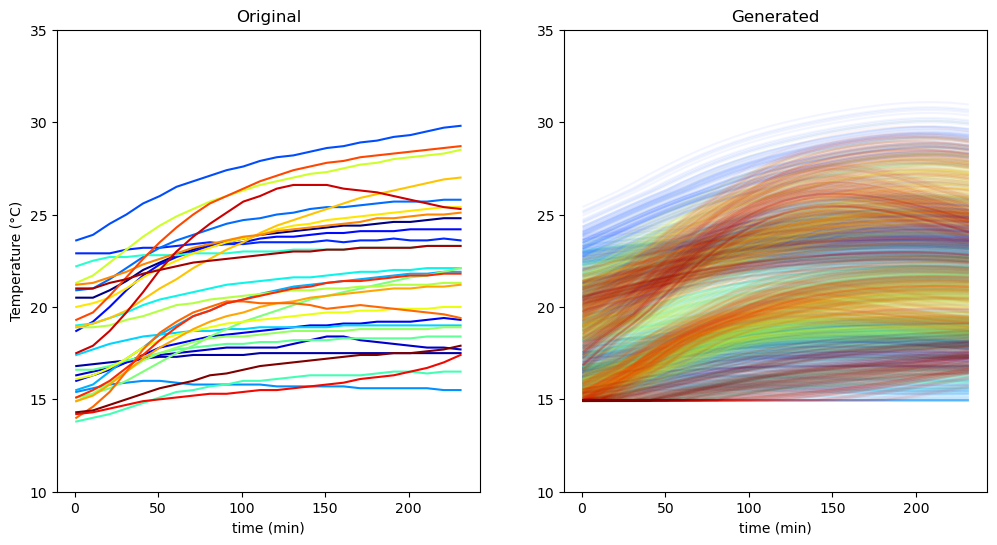

In [16]:
ns = 100
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_ylim(10, 35)
axs[1].set_ylim(10, 35)

colors = plt.cm.jet(np.linspace(0, 1, len(q_mu_l)))

for l, color in zip(range(len(q_mu_l)), colors):
    mu_list, var_list = [], []
    for i in range(latent_dim):
        with torch.no_grad():
            mu, var, _ = model.GP(X=t_uni/240, y=q_mu_l[l], q_var=q_var_l[l].squeeze())
            mu_list.append(mu)
            var_list.append(var)

    for i in range(ns):
        with torch.no_grad():
            z = model.reparameterization(mu, var.diag())
            dec = model.decode(z)
        axs[1].plot(t_uni, dec.numpy(), color=color, alpha=0.05)

interval_indices = {interval: idx for idx, interval in enumerate(df_h['interval'].unique())}

for i in df_h['interval'].unique():
    id = df_h['interval'] == i
    axs[0].plot(df_h[id]['time_within_interval'].to_numpy(), df_h[id]['B.RTD1'].to_numpy(), color=colors[interval_indices[i]])

axs[1].set_title('Generated')
axs[1].set_xlabel('time (min)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_title('Original')
axs[0].set_xlabel('time (min)')
# plt.savefig("../figs/GP_cool_cond.pdf", format='pdf')
plt.show()


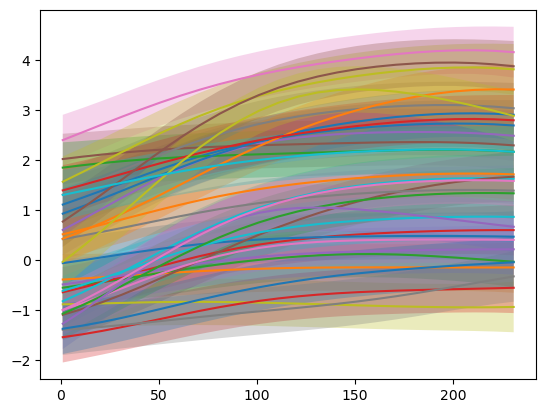

In [17]:
# Plot latent represenatations of the data
for l in range(len(q_mu_l)):
    with torch.no_grad():
        z_mu, z_var = model.GP.cond_mu_cov(t_uni/240, t_uni/240, q_mu_l[l], q_var_l[l].squeeze())
        plt.plot(t_uni,z_mu)
        plt.fill_between(t_uni, y1=z_mu.squeeze()+1.96*z_var.diag().sqrt(), y2=z_mu.squeeze()-1.96*z_var.diag().sqrt(),alpha=0.3, label='1.96*std')

plt.show()  #

In [18]:
mu_s = torch.cat(q_mu_l, dim=1).mean(dim=1).unsqueeze(1)

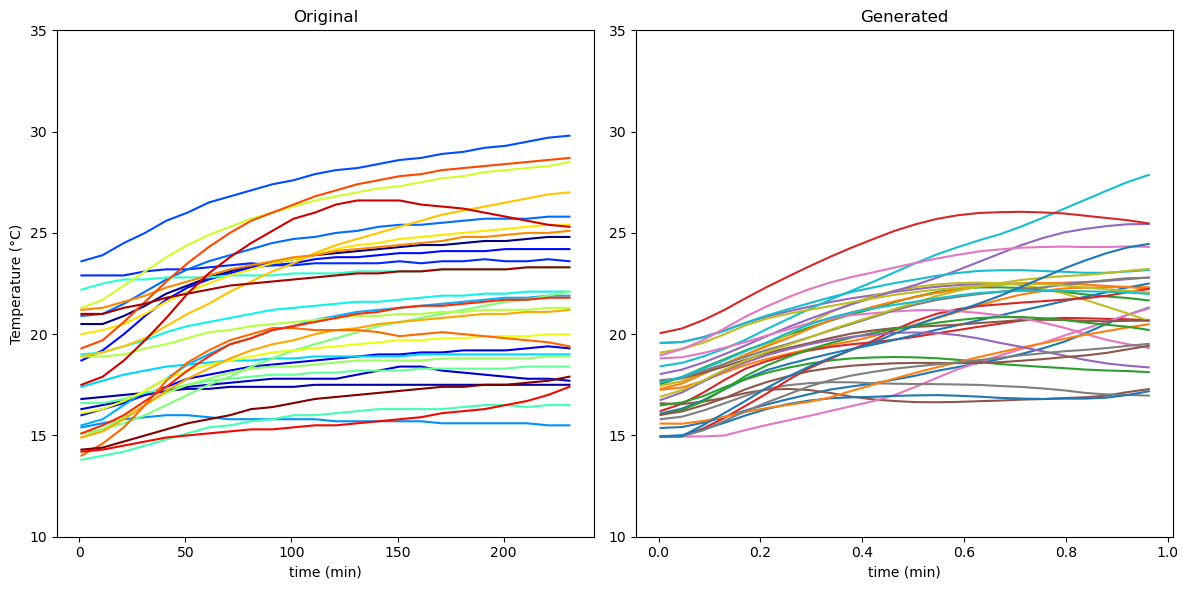

In [19]:
ns=total_size
generated_data, fig = model.generate_and_plot(mu_s, t_uni/240, ns, (10, 35), df_h, plot=True, seed=0)


In [20]:
import tsgm
mmd_metric = tsgm.metrics.MMDMetric()
Gd = torch.stack(generated_data)
full_data = DataLoader(dataset)
original_data_list = []

# Iterate through the DataLoader
for batch in full_data:
    # Each batch is expected to be of shape [24, 1]
    # Add to the list
    original_data_list.append(batch[0][:,0])

# Stack to create a tensor of shape [total_samples, 24, 1]
original_data = torch.stack(original_data_list)
original_data = original_data.unsqueeze(-1)
# Check the shape
# print(original_data.shape)
mmd_metric(original_data, Gd)

0.07312446390278637

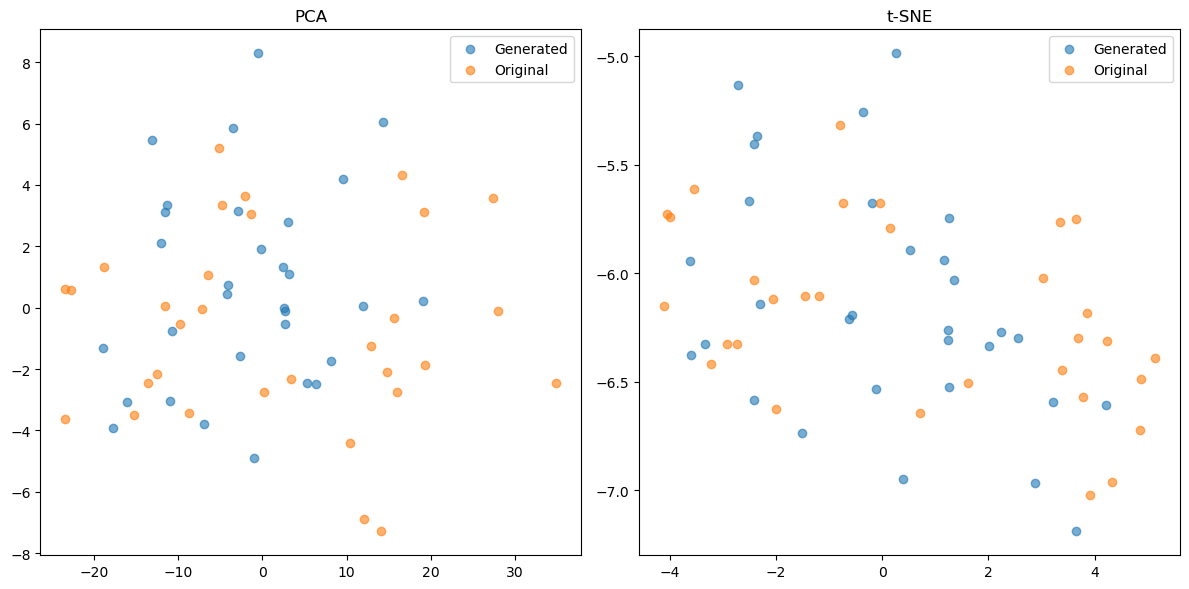

In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assume Gd and original_data are your generated and original data

# Reshape data to 2D format (num_samples, num_features)
Gd_reshaped = Gd.view(Gd.size(0), -1).numpy()
original_data_reshaped = original_data.view(original_data.size(0), -1).numpy()

# Concatenate generated and original data for visualization
data_combined = np.concatenate([Gd_reshaped, original_data_reshaped], axis=0)
labels = np.array(['Generated'] * Gd.size(0) + ['Original'] * original_data.size(0))

# PCA Visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_combined)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for label in np.unique(labels):
    plt.scatter(pca_result[labels == label, 0], pca_result[labels == label, 1], label=label, alpha=0.6)
plt.title("PCA")

plt.legend()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_combined)

plt.subplot(1, 2, 2)
for label in np.unique(labels):
    plt.scatter(tsne_result[labels == label, 0], tsne_result[labels == label, 1], label=label, alpha=0.6)
plt.title("t-SNE")

plt.legend()

plt.tight_layout()
plt.show()

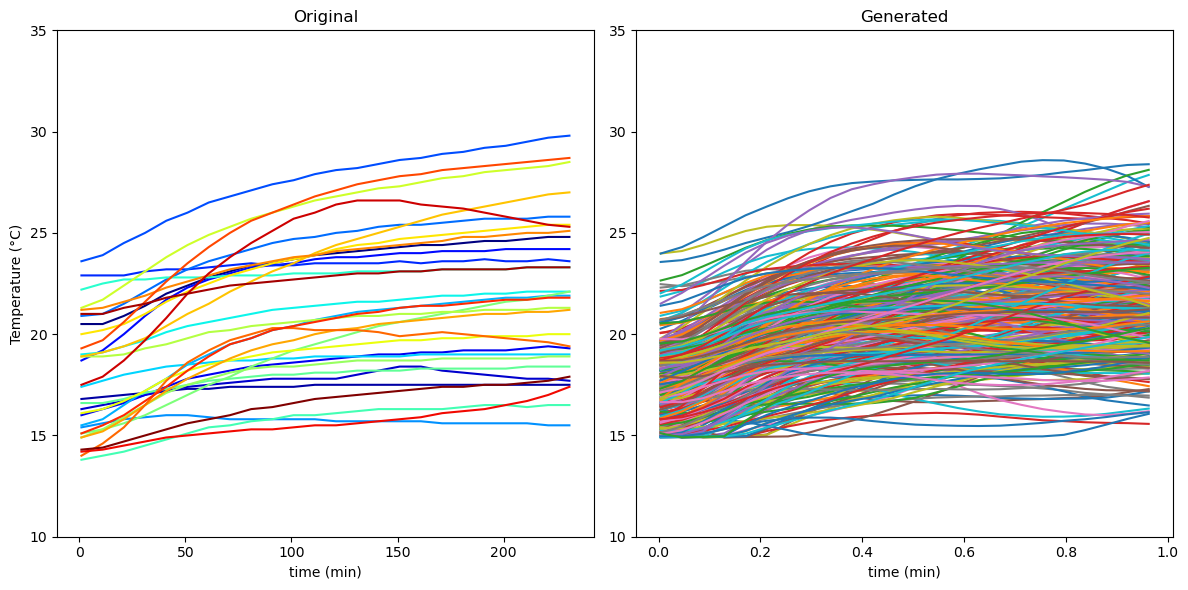

In [30]:
ns=300
generated_data, fig = model.generate_and_plot(mu_s, t_uni/240, ns, (10, 35), df_h, plot=True, seed=0)
Gd = torch.stack(generated_data)

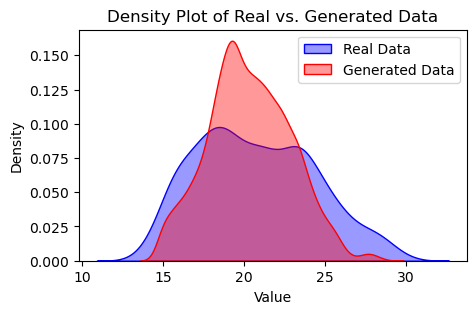

In [33]:
# Flatten the real and generated data to be one-dimensional
original_data_flattened = original_data.view(-1).numpy()
Gd = torch.stack(generated_data)
generated_data_flattened = Gd.view(-1).numpy()

# Plot overlapping density plots
plt.figure(figsize=(5, 3))
sns.kdeplot(original_data_flattened, label="Real Data", color="blue", fill=True, alpha=0.4)
sns.kdeplot(generated_data_flattened, label="Generated Data", color="red", fill=True, alpha=0.4)

# Customize plot
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Real vs. Generated Data')
plt.legend()
plt.show()


In [35]:
original_data.shape

torch.Size([31, 24, 1])

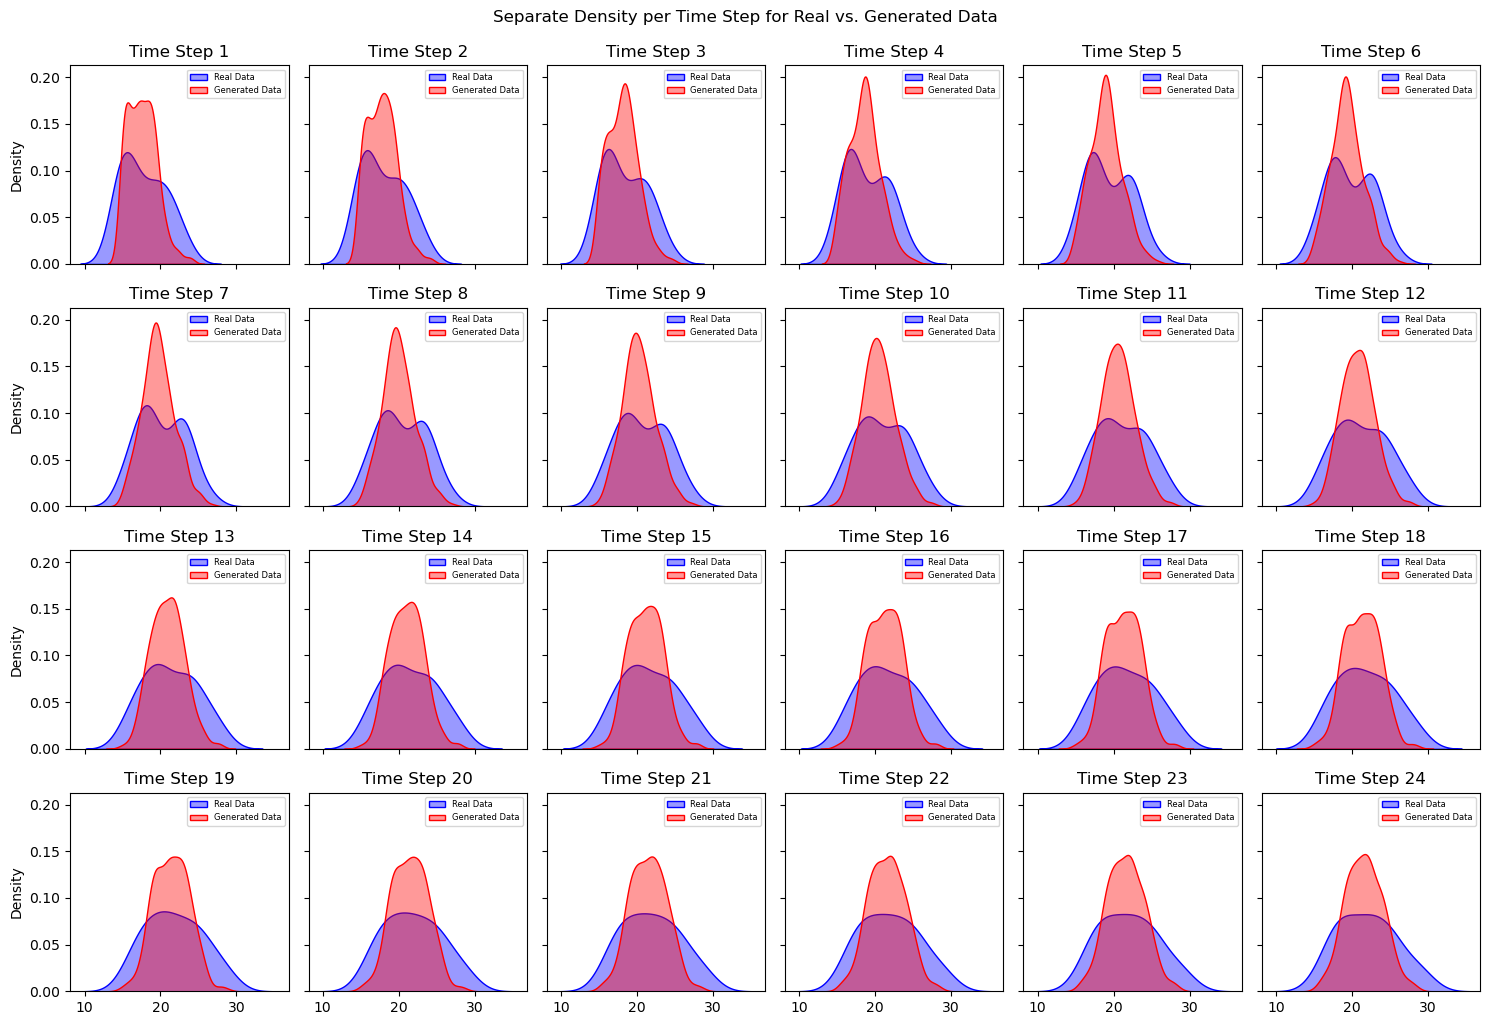

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for real and generated samples
original_data_windowed = original_data.view(31, 24).numpy()  # shape (28, 24)
generated_data_windowed = Gd.view(ns, 24).numpy()  # shape (ns, 24)

# Set up the number of subplots (one for each time step)
num_time_steps = 24
fig, axes = plt.subplots(4, 6, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Loop through each time step and plot density
for t in range(num_time_steps):
    # Extract the values at time step `t` for real and generated data
    real_values_at_t = original_data_windowed[:, t]
    generated_values_at_t = generated_data_windowed[:, t]
    
    # Plot density for real and generated data at each time step
    sns.kdeplot(real_values_at_t, ax=axes[t], label="Real Data", color="blue", fill=True, alpha=0.4)
    sns.kdeplot(generated_values_at_t, ax=axes[t], label="Generated Data", color="red", fill=True, alpha=0.4)
    
    # Label each subplot
    axes[t].set_title(f'Time Step {t + 1}')
    axes[t].legend(loc='upper right', fontsize=6)

# Adjust layout and add global labels
plt.tight_layout()
fig.suptitle('Separate Density per Time Step for Real vs. Generated Data', y=1.02)
plt.show()


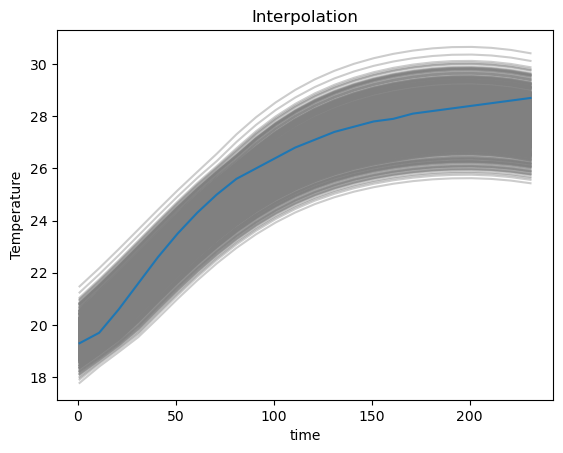

In [23]:
num_samples = 1000
dec_values = []
for i, batch in enumerate(val_loader):
    if i == 5:  
        y = batch[0, :, 0]
        break
    
X = t_uni/240
X_c = X
# q_var = mean_q_var.mean()
with torch.no_grad():
    x_hat, mu_p, cov_p, ll, q_mu, q_var = model(batch.squeeze())
# Disable gradient calculations
with torch.no_grad():
    # Get mean and covariance predictions
    # mu_p, cov_p = model.GP.cond_mu_cov(X, X_c, q_mu, q_var)
    
    # Loop to generate multiple `z` samples
    for i in range(num_samples):  # Define num_samples as needed
        # Reparameterize to get z (using diagonal of covariance)
        z = model.reparameterization(mu_p, cov_p.diag())
        dec = model.decode(z)
        # Store z for plotting
        dec_values.append(dec)

# Convert stored z values to a tensor for easy manipulation
z_values = torch.stack(dec_values)

# Assuming z_values and y have the same length

for i, dec in enumerate(dec_values):
    plt.plot(X_c.numpy()*240,dec.numpy(), color="grey", alpha=0.4)
plt.plot(X.numpy()*240,y.numpy(), label="y")
plt.xlabel("time")
plt.ylabel("Temperature")
# plt.legend()
plt.title("Interpolation")
plt.show()


In [24]:
z.shape

torch.Size([24, 1])

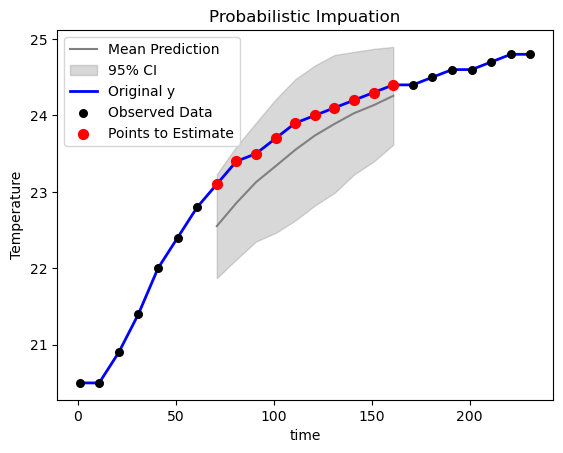

In [42]:
# Set number of samples
num_samples = 1000
dec_values = []

# Load batch data and select the y values
for i, batch in enumerate(val_loader):
    if i == 0:  
        y = batch[0, :, 0]
        break

X = t_uni / 240  # Define X and normalize

# Calculate middle index and select 5 middle points to remove
num_points_to_remove = 10
mid_index = len(X) // 2  # Middle index
start_index = mid_index - num_points_to_remove // 2
indices_to_remove = torch.arange(start_index, start_index + num_points_to_remove)

# Extract points to estimate and remove them from X, y, and batch
X_to_estimate = X[indices_to_remove]
y_to_estimate = y[indices_to_remove]
batch_to_estimate = batch[:, indices_to_remove, :]

# Create a mask for filtering
mask = torch.ones(len(X), dtype=bool)
mask[indices_to_remove] = False

# Filter out the selected points from X, y, and batch
X_filtered = X[mask]
y_filtered = y[mask]
batch_filtered = batch[:, mask, :]

# Set X_c to the missing middle points
X_c = X_to_estimate.unsqueeze(-1)

# Model evaluation with filtered batch
with torch.no_grad():
    # Calculate model outputs using the modified batch
    x_hat, mu_p_, cov_p_, ll, q_mu, q_var = model(batch_filtered.squeeze())

    # Get mean and covariance predictions on X_filtered and X_c using q_mu and q_var
    mu_p, cov_p = model.GP.cond_mu_cov(X_filtered, X_c, q_mu, q_var)
    
    # Loop to generate multiple `z` samples for interpolation
    for i in range(num_samples):
        # Reparameterize to get z
        z = model.reparameterization(mu_p, cov_p.diag())
        z = z.unsqueeze(1)
        dec = model.decode(z)
        # Store dec for plotting
        dec_values.append(dec)

# Convert stored dec values to a tensor for easy manipulation
dec_values = torch.stack(dec_values)  # Shape: (num_samples, num_points, 1)

# Calculate the mean and 95% confidence intervals
mean_dec = dec_values.mean(dim=0).squeeze()  # Mean along the sample dimension
std_dec = dec_values.std(dim=0).squeeze()    # Standard deviation along the sample dimension
ci_lower = mean_dec - 1.96 * std_dec         # Lower bound of 95% CI
ci_upper = mean_dec + 1.96 * std_dec         # Upper bound of 95% CI

# Plot the mean and 95% confidence intervals as shaded areas
plt.plot(X_c.numpy() * 240, mean_dec.numpy(), color="grey", label="Mean Prediction")
plt.fill_between(X_c.numpy().squeeze() * 240, ci_lower.numpy(), ci_upper.numpy(), color="grey", alpha=0.3, label="95% CI")

# Plot the original data, observed data points, and missing points for estimation
plt.plot(X.numpy() * 240, y.numpy(), label="Original y", color="blue", linewidth=2)
plt.scatter(X_filtered.numpy() * 240, y_filtered.numpy(), color="black", s=30, label="Observed Data", zorder=2)  # Black dots for observed data
plt.scatter(X_to_estimate.numpy() * 240, y_to_estimate.numpy(), color="red", s=50, label="Points to Estimate", zorder=3)  # Red dots for missing points

plt.xlabel("time")
plt.ylabel("Temperature")
plt.title("Probabilistic Impuation")
plt.legend()
plt.show()


Overall MAE across all validation batches: 0.38449451327323914


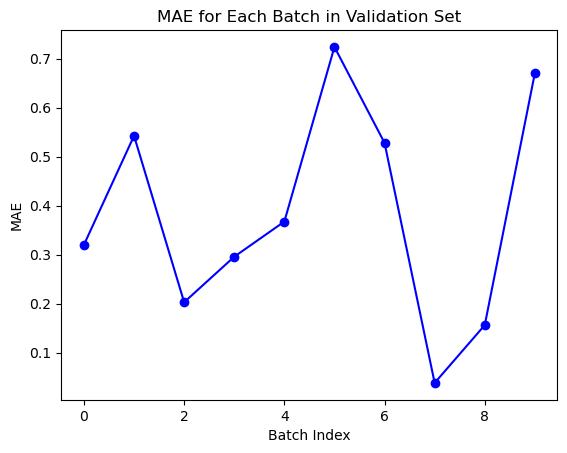

In [45]:
# Set number of samples
num_samples = 1000
all_mae_values = []  # Store MAE values for each batch

# Iterate through the entire validation loader
for batch in val_loader:
    # Select the y values from the current batch
    y = batch[0, :, 0]  # Assuming y is the target variable in the first dimension
    
    X = t_uni / 240  # Define X and normalize

    # Calculate middle index and select points to remove for imputation
    num_points_to_remove = 10
    mid_index = len(X) // 2
    start_index = mid_index - num_points_to_remove // 2
    indices_to_remove = torch.arange(start_index, start_index + num_points_to_remove)

    # Extract points to estimate and remove them from X, y, and batch
    X_to_estimate = X[indices_to_remove]
    y_to_estimate = y[indices_to_remove]
    batch_to_estimate = batch[:, indices_to_remove, :]

    # Create a mask to filter out selected points from X, y, and batch
    mask = torch.ones(len(X), dtype=bool)
    mask[indices_to_remove] = False

    X_filtered = X[mask]
    y_filtered = y[mask]
    batch_filtered = batch[:, mask, :]

    # Set X_c to the missing points
    X_c = X_to_estimate.unsqueeze(-1)

    # Model evaluation with filtered batch
    with torch.no_grad():
        # Calculate model outputs using the modified batch
        x_hat, mu_p_, cov_p_, ll, q_mu, q_var = model(batch_filtered.squeeze())

        # Get mean and covariance predictions on X_filtered and X_c using q_mu and q_var
        mu_p, cov_p = model.GP.cond_mu_cov(X_filtered, X_c, q_mu, q_var)
        
        # Loop to generate multiple `z` samples for interpolation
        dec_values = []
        for i in range(num_samples):
            # Reparameterize to get z
            z = model.reparameterization(mu_p, cov_p.diag())
            z = z.unsqueeze(1)
            dec = model.decode(z)
            # Store dec for computation
            dec_values.append(dec)
        
        # Convert stored dec values to a tensor
        dec_values = torch.stack(dec_values)  # Shape: (num_samples, num_points, 1)

        # Calculate the mean prediction across samples
        mean_dec = dec_values.mean(dim=0).squeeze()  # Mean along the sample dimension

        # Calculate MAE between the estimated (mean_dec) and the original y_to_estimate
        mae = torch.mean(torch.abs(mean_dec - y_to_estimate))
        all_mae_values.append(mae.item())  # Store MAE for this batch

# Compute overall MAE across all batches in val_loader
overall_mae = sum(all_mae_values) / len(all_mae_values)
print(f"Overall MAE across all validation batches: {overall_mae}")

# Optional: plot the MAE values across batches
plt.plot(all_mae_values, marker='o', linestyle='-', color="blue")
plt.xlabel("Batch Index")
plt.ylabel("MAE")
plt.title("MAE for Each Batch in Validation Set")
plt.show()


Overall MAE across all validation batches: 0.70715961009264


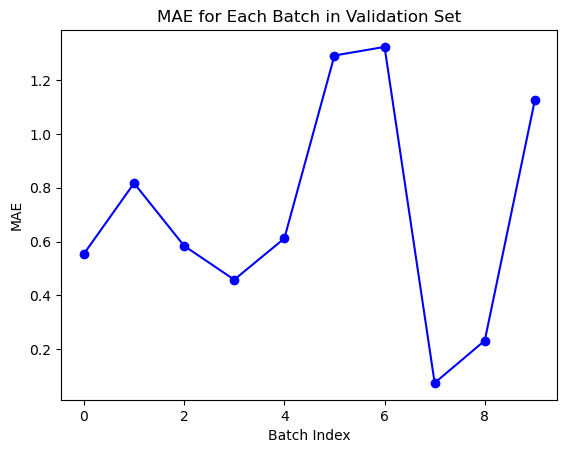

In [44]:
# Set number of samples
num_samples = 1000
all_mae_values = []  # Store MAE values for each batch

# Iterate through the entire validation loader
for batch in val_loader:
    # Select the y values from the current batch
    y = batch[0, :, 0]  # Assuming y is the target variable in the first dimension
    
    X = t_uni / 240  # Define X and normalize

    # Calculate middle index and select points to remove for imputation
    num_points_to_remove = 15
    mid_index = len(X) // 2
    start_index = mid_index - num_points_to_remove // 2
    indices_to_remove = torch.arange(start_index, start_index + num_points_to_remove)

    # Extract points to estimate and remove them from X, y, and batch
    X_to_estimate = X[indices_to_remove]
    y_to_estimate = y[indices_to_remove]
    batch_to_estimate = batch[:, indices_to_remove, :]

    # Create a mask to filter out selected points from X, y, and batch
    mask = torch.ones(len(X), dtype=bool)
    mask[indices_to_remove] = False

    X_filtered = X[mask]
    y_filtered = y[mask]
    batch_filtered = batch[:, mask, :]

    # Set X_c to the missing points
    X_c = X_to_estimate.unsqueeze(-1)

    # Model evaluation with filtered batch
    with torch.no_grad():
        # Calculate model outputs using the modified batch
        x_hat, mu_p_, cov_p_, ll, q_mu, q_var = model(batch_filtered.squeeze())

        # Get mean and covariance predictions on X_filtered and X_c using q_mu and q_var
        mu_p, cov_p = model.GP.cond_mu_cov(X_filtered, X_c, q_mu, q_var)
        
        # Loop to generate multiple `z` samples for interpolation
        dec_values = []
        for i in range(num_samples):
            # Reparameterize to get z
            z = model.reparameterization(mu_p, cov_p.diag())
            z = z.unsqueeze(1)
            dec = model.decode(z)
            # Store dec for computation
            dec_values.append(dec)
        
        # Convert stored dec values to a tensor
        dec_values = torch.stack(dec_values)  # Shape: (num_samples, num_points, 1)

        # Calculate the mean prediction across samples
        mean_dec = dec_values.mean(dim=0).squeeze()  # Mean along the sample dimension

        # Calculate MAE between the estimated (mean_dec) and the original y_to_estimate
        mae = torch.mean(torch.abs(mean_dec - y_to_estimate))
        all_mae_values.append(mae.item())  # Store MAE for this batch

# Compute overall MAE across all batches in val_loader
overall_mae = sum(all_mae_values) / len(all_mae_values)
print(f"Overall MAE across all validation batches: {overall_mae}")

# Optional: plot the MAE values across batches
plt.plot(all_mae_values, marker='o', linestyle='-', color="blue")
plt.xlabel("Batch Index")
plt.ylabel("MAE")
plt.title("MAE for Each Batch in Validation Set")
plt.show()
